### Practical Lab 7: K-means Clustering

*This notebook used similar codes from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas

* This lab demonstrates how to use k-means clustering. 


In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [134]:
# helper function:
# return index in input belonging to different classes
def decision(X,y):
    index_0 = (y == 0)
    index_1 = (y == 1)
    index_2 = (y == 2)
    index_3 = (y == 3)
    
    return X[index_0], X[index_1], X[index_2], X[index_3]
    

In [135]:

# Data generation
## generate random data from 4 different Gaussian distributions 
##(implicitly from 4 clusters)

# the number of data points for each cluster
n_samples = 200

# the Covariance for Gaussian distributions
C = np.array([[.5, 2.1], [1.7, 1.4]])

# Generate the inputs randomly
X1 =[4,5]+ np.dot(np.random.randn(n_samples, 2), C)
X2 =[-4,-5]+ np.dot(np.random.randn(n_samples, 2), C)
X3 =[-5,5]+ np.dot(np.random.randn(n_samples, 2), C)
X4 =[5,-5]+ np.dot(np.random.randn(n_samples, 2), C)

# Just give the ground-truth labels (0,1,2,3)
# (Unsupervised-learning does not use)
Y1 =  np.ones(n_samples).reshape((n_samples,1))
Y2 =  2*np.ones(n_samples).reshape((n_samples,1))
Y3 =  3*np.ones(n_samples).reshape((n_samples,1))
Y4 =  np.zeros(n_samples).reshape((n_samples,1))

y = np.vstack([Y1,Y2,Y3,Y4]).flatten()
X = np.vstack([X1,X2,X3,X4])


print ("data.shape:", X.shape,y.shape)


data.shape: (800, 2) (800,)


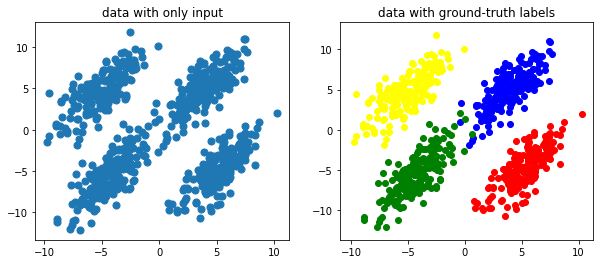

In [136]:
# Inspect the data

X1,X2,X3,X4 = decision(X,y)

# plotting only input data (supervised learning problem)
fig = plt.figure(figsize=(10, 4))
#fig, sub = plt.subplots(2, 1)
ax = fig.add_subplot(121) # the projection arg is important!
plt.scatter(X[:, 0], X[:, 1], s=50);
ax.set_title("data with only input")


ax1 = fig.add_subplot(122) # the projection arg is important!
ax1.scatter(X1[:, 0], X1[:, 1], color="red")
ax1.scatter(X2[:, 0], X2[:, 1], color="blue")
ax1.scatter(X3[:, 0], X3[:, 1], color="green")
ax1.scatter(X4[:, 0], X4[:, 1], color="yellow")
ax1.set_title("data with ground-truth labels")
plt.draw()


### k-Means Algorithm: using scikit-learn

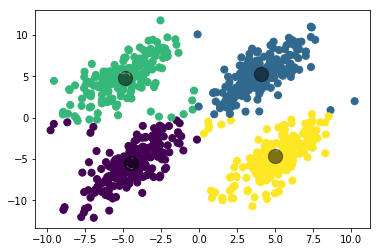

In [137]:
# Using scikit-learn library: https://scikit-learn.org/stable/
from sklearn.cluster import KMeans
## try to build 4 centroids/centers
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

## predict the assignments
y_kmeans = kmeans.predict(X)

## Visualize the results
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

## scattering 4 centroids/centers together with the assignments 
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5);

### k-Means Algorithm: from scratch
Let's implement k-means from scratch: we need a distance function (computing the distance function between two data points), finding nearest centroid, doing assignments, and update the centroids
K-means algorithm consists of the following procedure:

1. Guess some cluster centroids (randomly initialize the centroids)
2. Repeat until converged
   - Step 1: assign points to the nearest cluster centroid
   - Step 2: set the cluster centroids to the mean 

Step 1 in loop: involves updating the assignment (assign to which cluster) for each point.

Step 2 in loop: update the cluster centroid to the mean of its assignments.


In [138]:

# Euclidean Distance Caculator
# Compute the distance from all X to all centroids
# the return distance are in size of (n_data,n_centroids)
def Euclidean_Distance(X_data, centroids):
        
    n_centres = centroids.shape[0]
    distances = []
    for c in range(n_centres):        
        distance_to_c = np.linalg.norm(X_data - centroids[c], axis=1)
        distances.append(distance_to_c)
    return np.array(distances).T

# computing the error function for clustering
def computing_SSE(X,assignments,centroids):
    
    # initialize the within-cluster sum of square errors (SSE)
    SSE = 0
    n_centres = centroids.shape[0]
    
    for c in range(n_centres):  
        # extract only data points belong to centroid c
        X_c = X[assignments == c]   
        distance_to_c = np.linalg.norm(X_c - centroids[c], axis=1)
        distance_to_c = distance_to_c * distance_to_c
        SSE = SSE + np.sum(distance_to_c)
        #print(SSE)
        
    return SSE


In [142]:
# K-means clustering algorithm
# given input data, and the number of cluster to be discovered
# rseed is a random seed number
def find_clusters(X, n_clusters, rseed=100):
    # 1. Randomly choose clusters: pick a random data point to set as a centroid (try to pick n_clusters centroids)
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    # each centroid is put in one row of centroids
    centroids = X[i]
    
    iterations = 0    
    errors=[]
    
    while True:        
        # computing the distance from all data points to all centroids
        distances = Euclidean_Distance(X, centroids)
        print(distances.shape)
        # 1. Assign labels based on closest centroid. 
        assignments_index = np.argmin(distances,axis=1)       
        
        
        # 2. Find/update new centroids from means of points
        
        new_centroids = np.zeros(centroids.shape)        
        for i in range(n_clusters):
            # pick only rows that has assignment to class i
            new_centroids[i] = X[assignments_index == i].mean(0)        
        
        # 3. Check for convergence (if the centroid does not move)
        # we can also check the SSE (error)
        if np.all(centroids == new_centroids):
            break
        
        centroids = new_centroids
        
        iterations = iterations + 1
        # computing the 
        SSE = computing_SSE(X, assignments_index, centroids)
        print("iteration: ",iterations," the within-cluster square error is: ",SSE)
        errors.append(SSE)     
        
    
    return  centroids, assignments_index, errors


In [140]:
# Code test for clustering
centroids, assignments, errors = find_clusters(X, 4)


iteration:  1  the within-cluster square error is:  13717.703657208554
iteration:  2  the within-cluster square error is:  9051.721379235207
iteration:  3  the within-cluster square error is:  7154.938562749117
iteration:  4  the within-cluster square error is:  6964.753191054148
iteration:  5  the within-cluster square error is:  6959.194028947762
iteration:  6  the within-cluster square error is:  6957.664491810465
iteration:  7  the within-cluster square error is:  6957.189498539078


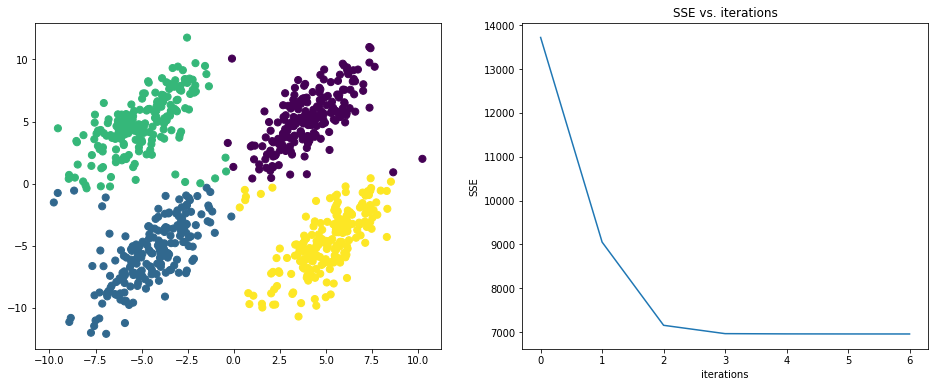

In [141]:
# Visulization the found clusters and error plotting.
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121)

plt.scatter(X[:, 0], X[:, 1], c=assignments, s=50, cmap='viridis');


ax = fig.add_subplot(122)
ax.set_title("SSE vs. iterations")
ax.set_xlabel('iterations')
ax.set_ylabel('SSE')
plt.plot(errors)